### 05: Exploratory Data Analysis, Individual Level
##### Group 12:

##### Hannah Schmuckler, mmc4cv

##### Rob Schwartz, res7cd

At a minimum, the file should include a summary containing:
* Number of records
* Number of columns
* Statistical summary of response variable
* Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
* Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
* Include up to five helpful graphs

In [2]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql import types as T
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.window import Window


import sys
spark = SparkSession.builder \
        .appName("project") \
        .getOrCreate()

sc = spark.sparkContext

CPU times: user 682 µs, sys: 0 ns, total: 682 µs
Wall time: 819 µs


### Read in data

#### Note: Our data was originally formatted in a 'tall' file forma with 9 columns:
* event_time
* event_type
* product_id
* category_code
* brand
* price
* user_id
* user_session

It was also significantly larger than the 3gb limitation for class. To address the size issue, we selected a random sample of individuals. 

All of the features in the dataset below have been engineered by us on an individual level, instead of the event-level data originally provided. 

In [3]:
full = spark.read.parquet("./processed_data/engineered_features.parquet")

In [4]:
full.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- m2_total_spend: double (nullable = true)
 |-- m1_total_spend: double (nullable = true)
 |-- m1_total_events: long (nullable = true)
 |-- m1_purchase_events: long (nullable = true)
 |-- m1_user_sessions: long (nullable = true)
 |-- num_sessions_month: long (nullable = true)
 |-- AvgSessLen: double (nullable = true)
 |-- stddev_SessionLengthSecs: double (nullable = true)
 |-- avg_interactions_per_session: double (nullable = true)
 |-- stddev_int_per_session: double (nullable = true)
 |-- max_interactions_one_session: long (nullable = true)
 |-- purchase_pct_of_total_events: double (nullable = true)
 |-- cart_pct_of_total_events: double (nullable = true)
 |-- view_pct_of_total_events: double (nullable = true)
 |-- avg_purchases_per_session: double (nullable = true)
 |-- std_purchases_per_session: double (nullable = true)
 |-- monthlyCartTotal: long (nullable = true)
 |-- monthlyPurchaseTotal: long (nullable = true)
 |-- monthlyViewTotal: l

In [5]:
# Number of columns
len(full.schema)

25

##### A single record looks like this:

In [6]:
%%time
full.show(1, vertical=True)

-RECORD 0------------------------------------------
 user_id                      | 413580824          
 m2_total_spend               | 0.0                
 m1_total_spend               | 0.0                
 m1_total_events              | 3                  
 m1_purchase_events           | 0                  
 m1_user_sessions             | 2                  
 num_sessions_month           | 3                  
 AvgSessLen                   | 38.5               
 stddev_SessionLengthSecs     | 54.44722215136416  
 avg_interactions_per_session | 1.5                
 stddev_int_per_session       | 0.7071067811865476 
 max_interactions_one_session | 2                  
 purchase_pct_of_total_events | 0.0                
 cart_pct_of_total_events     | 0.0                
 view_pct_of_total_events     | 1.0                
 avg_purchases_per_session    | 0.0                
 std_purchases_per_session    | 0.0                
 monthlyCartTotal             | 0                  
 monthlyPurc

In [7]:
%%time
## Note: We have not yet determined our best predictors, but perhaps looking at these outputs will help us.
for i in range(1,len(full.columns)):
    j = full.columns[i]
    full.select(j).summary().show()

+-------+-------------------+
|summary|     m2_total_spend|
+-------+-------------------+
|  count|             219080|
|   mean| 3911.7643793777147|
| stddev|  231481.4145618852|
|    min|                0.0|
|    25%|                0.0|
|    50%|                0.0|
|    75%|                0.0|
|    max|8.611105072402954E7|
+-------+-------------------+

+-------+------------------+
|summary|    m1_total_spend|
+-------+------------------+
|  count|            219080|
|   mean|375.27011449155697|
| stddev|26808.034855558904|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|               0.0|
|    max|  8298110.25957489|
+-------+------------------+

+-------+-----------------+
|summary|  m1_total_events|
+-------+-----------------+
|  count|           219080|
|   mean|23.83292404601059|
| stddev| 785.672172369044|
|    min|                1|
|    25%|                1|
|    50%|                4|
|    75%|               11|
|    max| 

There are additional features that are not yet fully integrated in our engineered features. Here is our original dataset so we can do some basic summary of things like product_id, brand and individual price. 

Note that period is a feature that we added after filtering the data to easily keep track of which month a given row is from. This is the month 1 dataset, where all our predictors will come from. The month 2 dataset (not in this document) has been aggregated above to produce our response variable. 

In [30]:
m1 = spark.read.parquet(./processed_data/month_01_filtered.parquet)

In [35]:
m1.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_session: string (nullable = true)
 |-- Period: integer (nullable = true)



In [37]:
# Number of columns
len(m1.schema)

10

In [97]:
m1.select('event_type').distinct().count()

3

In [31]:
%%time
m1.select('product_id').distinct().count()
# There are 181,283 different products. 

CPU times: user 3.26 ms, sys: 74 µs, total: 3.33 ms
Wall time: 1.9 s


181283

In [32]:
%%time
m1.select('category_code').distinct().count()
# There are 136 different categories

CPU times: user 187 µs, sys: 2.83 ms, total: 3.02 ms
Wall time: 1.21 s


136

In [34]:
%%time
m1.select('brand').distinct().count()
# There are 4770 different brands

CPU times: user 766 µs, sys: 2.65 ms, total: 3.42 ms
Wall time: 1.29 s


4770

In [42]:
m1.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|         15923973|
|   mean|272.8108554043269|
| stddev|334.8869399729803|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



In [43]:
%%time
m1.select('user_session').distinct().count()
# There are 2697902 different user sessions

CPU times: user 1.57 ms, sys: 1.73 ms, total: 3.3 ms
Wall time: 2.15 s


2697902

### Visualization

##### Response Variable: Spend in month 2

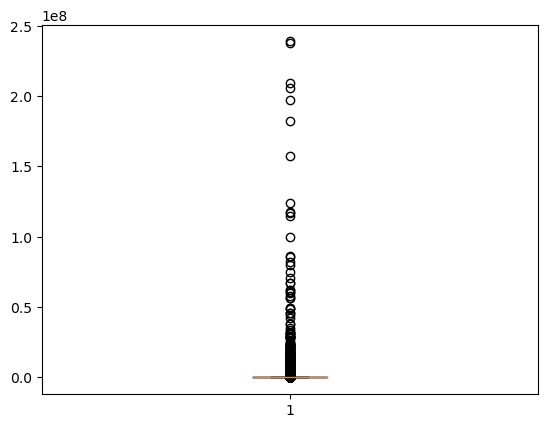

In [49]:
response = full.select('m2_total_spend').toPandas()['m2_total_spend']
plt.boxplot(response)
plt.show()

That's essentially useless, we're obviously going to have to do some transformation on our response and remove outliers, but here's a histogram:

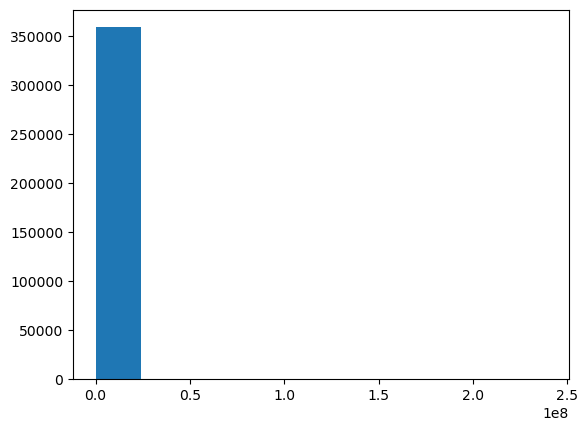

In [50]:
plt.hist(response)
plt.show()

### Just to get an idea of how common purchases are...

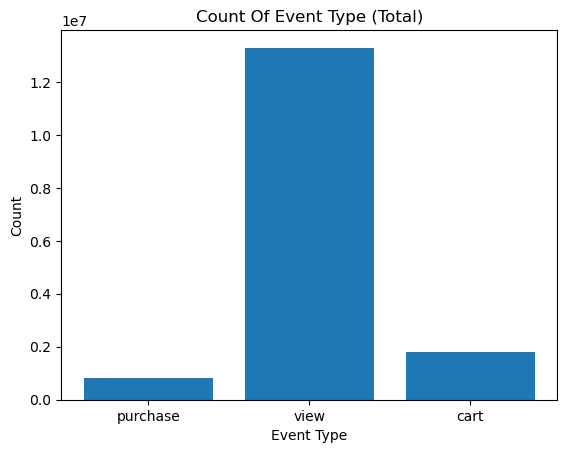

In [89]:
events = m1.groupBy('event_type').count()
x = events.select('event_type').toPandas()['event_type']
y = events.select('count').toPandas()['count']

plt.bar(x, y)
plt.title("Count Of Event Type (Total)")
plt.xlabel("Event Type")
plt.ylabel("Count")


plt.show()

#### To get an idea of the variation in behavior...standard deviation of interactions per session

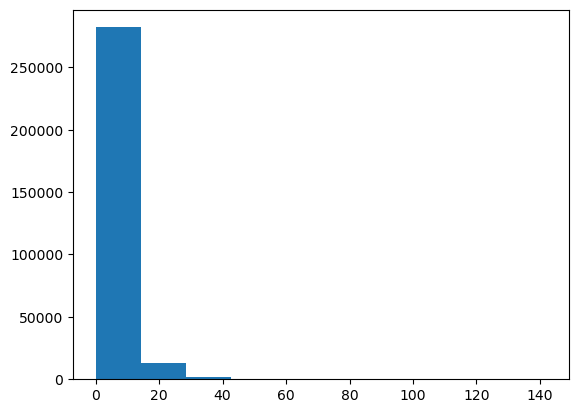

In [95]:
response = full.select('stddev_int_per_session').toPandas()['stddev_int_per_session']
plt.hist(response)
plt.show()

#### Average Purchases Per Session

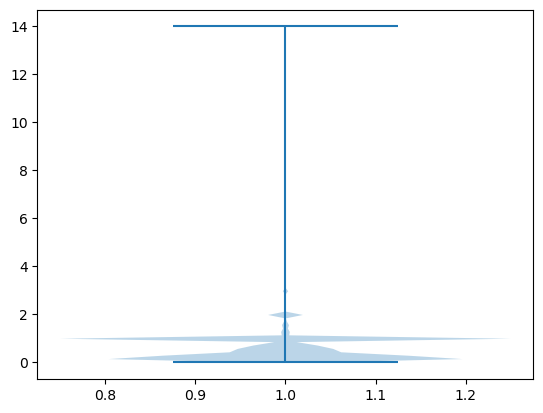

In [94]:
response = full.select('avg_purchases_per_session').toPandas()['avg_purchases_per_session']
plt.violinplot(response)
plt.show()
